# Lab One: Exploring Table Data
Team: Jack Babcock, Hayden Center, Fidelia Navar, Amory Weinzierl

### Assignment Description
You are to perform preprocessing and exploratory analysis of a data set: exploring the statistical summaries of the features, visualizing the attributes, and addressing data quality. This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output.

Additional information and requirements can be found at https://smu.instructure.com/courses/81978/assignments/465788

## Part I -  Business Understanding

The data set (which can be found at https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) that we have chosen to utilize for this lab consists of data that may be used to identify whether or not an individual is at risk for strokes.<br><br>
This data was likely collected by medical professionals in a medical trial with the goal of recognizing what attributes may contribute to the likelihood of a stroke in an individual. We may speculate that this was the given circumstances the data was collected under (although not explicitly said) because medical records are not publicly available and, thus, the patients involved would have had to have been aware that the data would be used for a study. Further, we can safely assume that the data was collected by medical professionals because they know what sort of attributes would be pertinent to increasing the chance of a stroke and it is in their interest to conduct studies of this sort to further their knowledge about such medical happenings.<br><br>
Given the attributes of the individuals involved in this dataset, ideally it would be possible to predict whether an individual is at heightened risk for strokes. This functionality would be valuable to third parties in the medical industry; an accurate diagnoses done with training and classification may remove the possibility of human error in false diagnoses or lack of diagnoses. Furthermore, I think this functionality may also be useful to general users; of course, an app should never replace a medical professional but, if an individual is health-conscious and deemed at high risk for strokes, an app may be helpful to keep track of changing statistics on an individual basis and how that may affect an individual's risk of stroke. For example, if an individual's BMI decreases or increases, an individual may put that change into the app and see how that may affect their risk.<br><br>
Quite simply, our prediction algorithm would need to perform better than its competitors. Performing better may be defined as less false positives and negatives. According to "Positive predictive value of stroke identification by ambulance clinicians in North East England: a service evaluation," 38% of diagnosed strokes between June 2013 and May 2016 were false positives. In 2012, the Dijon Stroke Registry identified 811 patients with a stroke, among who 186 were considered false-negatives. Further, of the 903 patients discharged following a stroke, 278 were found to be false positives (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566387/). As given in the preceding data, 23% of diagnosed strokes were false negatives and 31% of diagnosed strokes were false positives. Thus, our algorithm must be more accurate than the calculated percentage of false negatives and false positives to be considered more useful than at least human diagnoses. In terms of performing better than competing instruments, our algorithm must report better than 85% - 90% sensitivity (https://pubmed.ncbi.nlm.nih.gov/17678494/).<br><br>
Additional details to consider and implement in our algorithm may be characteristics of common misdiagnoses. According to the article "Stroke misdiagnosis -- why does it still happen," the misdiognosis of strokes is the most common medical negligence issue encountered by the sponsor of the article (https://www.browells.co.uk/stroke-misdiagnosis-still-happen/). For example, in younger patients, strokes are commonly misdiagnosed as false negatives where it is thought that the issue is veritgo or alcohol intoxication (https://journals.lww.com/neurotodayonline/fulltext/2009/04020/younger_stroke_patients_often_misdiagnosed.8.aspx). Thus, our algorithm must address these common misdiagnosis. It may do so by factoring in extra information to report if an individual is at high risk for misdiagnoses.

## Part II - Data Understanding

### Data Description

#### Importing

In [1]:
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df.head()

Pandas: 1.2.1
Numpy: 1.19.2


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Formatting

To clean up the data a little bit, we're going to normalize the values of the non-numeric columns to have the same format by setting all values to lowercase and replacing spaces with underscores.

In [2]:
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].str.lower()
        
df = df.replace(' ', '_', regex=True)
        
for c in df.columns:
    if df[c].dtype == 'object':
        print(df[c].unique())

['male' 'female' 'other']
['yes' 'no']
['private' 'self-employed' 'govt_job' 'children' 'never_worked']
['urban' 'rural']
['formerly_smoked' 'never_smoked' 'smokes' 'unknown']


All of the columns look good except for the smoking_status column. One of the values in that column is listed as 'unknown'. Though this is technically a value, what it is actually representing is missing information, so let's make that more clear.

In [3]:
df.smoking_status.mask(df.smoking_status == 'unknown', np.nan, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Some of the categorical columns should be converted into numerical columns. Specifically the ever_married column should be converted into a binary column similar to the hypertension, heart_disease, and stroke columns, and the smoking_status column should be converted into an ordinal. We think this is a meaningful change because there is a very clear way to assign an order to the values: never_smoked is 0, formerly_smoked is 1 since it is worse for your health, and finally smokes is 2, since it is worse than formerly_smoked.

In [4]:
df.smoking_status.replace(to_replace= ['never_smoked', 'formerly_smoked', 'smokes'], value = [0, 1, 2], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     3566 non-null   float64
 11  stroke             5110 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 479.2+ KB


In [5]:
df.drop(df[df.gender == 'other'].index, inplace=True)
df = df.reset_index()

### Data Quality

#### Duplicate Values

The first thing we'll want to do to check the quality of the data is to check for duplicates. First, let's make sure there are no duplicate IDs in the dataset.

In [6]:
if df.id.unique().size == df.id.size:
    print("No duplicate IDs")

No duplicate IDs


Now that we know there are no duplicate IDs, let's check if there are any rows with identical values (excluding the ID).

In [7]:
cols = df.columns.drop('id')

s = df.duplicated(subset=cols, keep='first')

s[s]

Series([], dtype: bool)

Seems like the dataset has no exact duplicates. We feel safe assuming that, finding no exact duplicates, each entry in the dataset is unique.

#### Missing Values

The second thing to check the dataset for is missing values. We can see them by checking df.info().

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              5109 non-null   int64  
 1   id                 5109 non-null   int64  
 2   gender             5109 non-null   object 
 3   age                5109 non-null   float64
 4   hypertension       5109 non-null   int64  
 5   heart_disease      5109 non-null   int64  
 6   ever_married       5109 non-null   object 
 7   work_type          5109 non-null   object 
 8   residence_type     5109 non-null   object 
 9   avg_glucose_level  5109 non-null   float64
 10  bmi                4908 non-null   float64
 11  smoking_status     3565 non-null   float64
 12  stroke             5109 non-null   int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 519.0+ KB


This shows us that we're missing data from two columns: smoking_status and bmi. Now let's take a look at both of the columns with missing data and see if we want to impute or delete them.

##### BMI

Let's first look at the inital data from the column.

In [9]:
df.bmi.describe()

count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64

Now let's attempt to impute the bmi column using KNNImputer with the numerical and boolean columns of the dataset.

In [10]:
from sklearn.impute import KNNImputer
import copy

knn = KNNImputer(n_neighbors=3)

temp = df[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]].to_numpy()

temp_imputed = knn.fit_transform(temp)

df_imputed = copy.deepcopy(df)
df_imputed[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'bmi',
    'stroke'
]] = temp_imputed

df_imputed.bmi = df_imputed.bmi.apply(lambda x: round(x, 1))
print("----- Original -----")
print(df.bmi.describe())
print("----- Imputed ------")
print(df_imputed.bmi.describe())

----- Original -----
count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64
----- Imputed ------
count    5109.000000
mean       28.950714
std         7.783311
min        10.300000
25%        23.700000
50%        28.200000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


From the averages and five number summary of the dataset before and after the imputation, we see that there is very little difference. The dataset seemed to impute slightly more datapoints just above the mean and in a tighter grouping. Let's now visualize the imputation using a histogram.

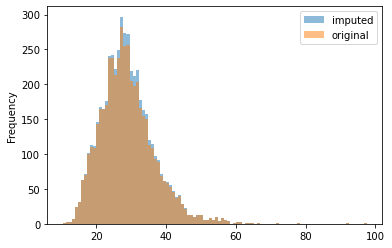

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

df_imputed.bmi.plot(kind='hist', alpha=0.5, label="imputed",bins=100)
df.bmi.plot(kind='hist', alpha=0.5, label="original",bins=100)
plt.legend()
plt.show()

The imputation looks very successful from this visualization, so we have decided to use the imputed data for our visualizations.

In [12]:
df = df_imputed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              5109 non-null   int64  
 1   id                 5109 non-null   int64  
 2   gender             5109 non-null   object 
 3   age                5109 non-null   float64
 4   hypertension       5109 non-null   float64
 5   heart_disease      5109 non-null   float64
 6   ever_married       5109 non-null   object 
 7   work_type          5109 non-null   object 
 8   residence_type     5109 non-null   object 
 9   avg_glucose_level  5109 non-null   float64
 10  bmi                5109 non-null   float64
 11  smoking_status     3565 non-null   float64
 12  stroke             5109 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 519.0+ KB


##### SMOKING_STATUS

Let's first look at the inital data from the column.

In [13]:
df.smoking_status.describe()

count    3565.000000
mean        0.690603
std         0.810242
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: smoking_status, dtype: float64

Now let's attempt to impute the smoking_status column using KNNImputer with the numerical and boolean columns of the dataset.

In [14]:
temp = df[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'smoking_status',
    'stroke'
]].to_numpy()

temp_imputed = knn.fit_transform(temp)

df_imputed = copy.deepcopy(df)
df_imputed[[
    'age',
    'hypertension',
    'heart_disease',
    'avg_glucose_level',
    'smoking_status',
    'stroke'
]] = temp_imputed

df_imputed.smoking_status = df_imputed.smoking_status.apply(lambda x: round(x))
print("----- Original -----")
print(df.smoking_status.describe())
print("----- Imputed ------")
print(df_imputed.smoking_status.describe())

----- Original -----
count    3565.000000
mean        0.690603
std         0.810242
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: smoking_status, dtype: float64
----- Imputed ------
count    5109.000000
mean        0.624193
std         0.746756
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: smoking_status, dtype: float64


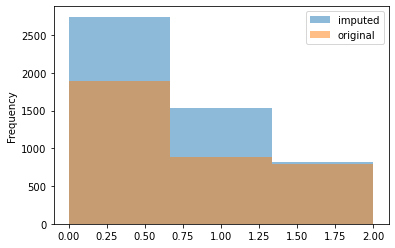

In [15]:
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

df_imputed.smoking_status.plot(kind='hist', alpha=0.5, label="imputed", bins=3)
df.smoking_status.plot(kind='hist', alpha=0.5, label="original",bins=3)
plt.legend()
plt.show()

This imputation seems to be much less successful than the previous one, imputing significantly more non-smoking and former-smoking datapoints than smoking datapoints. However, taking into account both how large the population with missing data is, and also real world factors that may influence this distribution, we have decided to use this imputated data as well. Regarding the real world factors, it seems plausible that smokers are more likely to be recorded as smokers due to the relevance of smoking to general health, whereas former- or non-smokers might not have that data recorded as often.

## Part III - Data Visualization

### Visualize basic feature distributions (5 plots).


Text(0.5, 1.0, 'Age / Stroke')

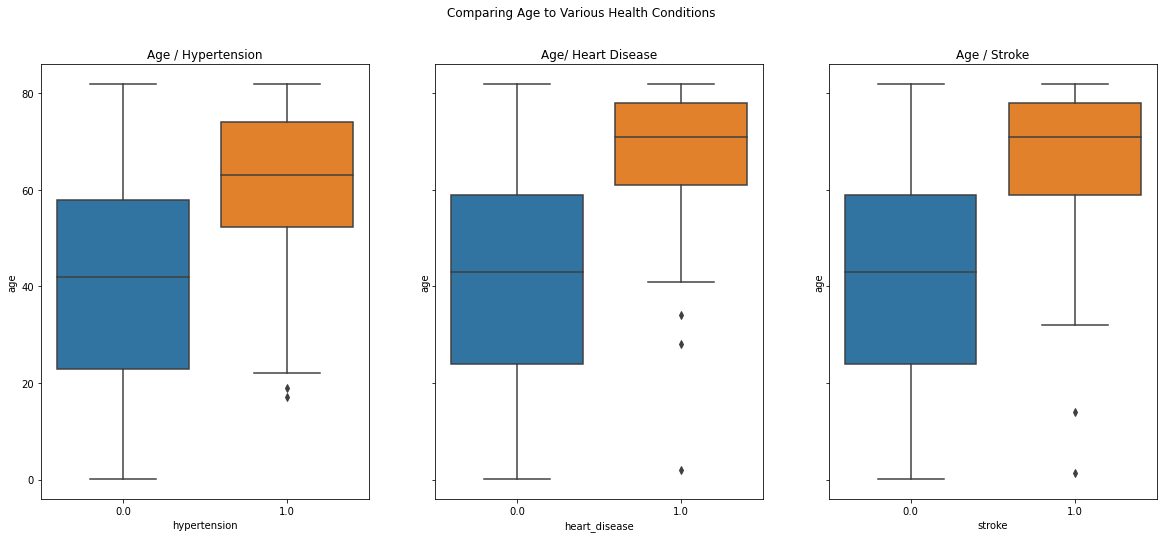

In [16]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
fig.suptitle('Comparing Age to Various Health Conditions')

sns.boxplot(ax = axes[0], x="hypertension", y="age", data=df_imputed)
axes[0].set_title('Age / Hypertension')

sns.boxplot(ax = axes[1], x="heart_disease", y="age", data=df_imputed)
axes[1].set_title('Age/ Heart Disease')

sns.boxplot(ax = axes[2], x="stroke", y="age", data=df_imputed)
axes[2].set_title('Age / Stroke')

This boxplot shows the relationship between age and various health conditions such as hypertension, heart disease, and occurrences of stroke. By analyzing the data, we can see how the majority of people with hypertension and heart disease fall into similar age groups (between about 50 to 80 years of age). This same age group is apparent with the people who have had a stroke before as well - they fall into the 60-80 years of age (for the majority). This can allow us to conclude how an older age factors into the occurrence of more health conditions like strokes, hypertension, and heart disease.

hypertension             False      True 
gender ever_married                      
female no            96.777442   3.222558
       yes           87.806097  12.193903
male   no            97.247706   2.752294
       yes           85.133136  14.866864

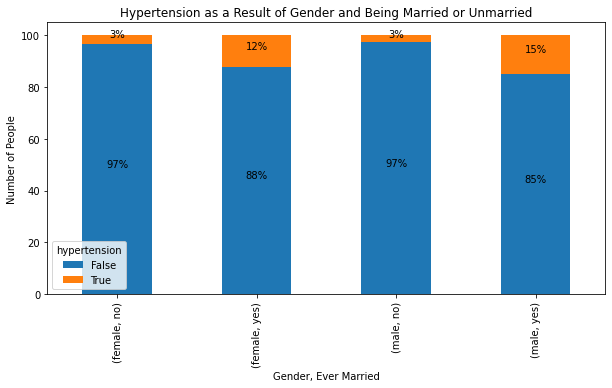

heart_disease            False      True 
gender ever_married                      
female no            98.288016   1.711984
       yes           95.202399   4.797601
male   no            98.034076   1.965924
       yes           89.053254  10.946746

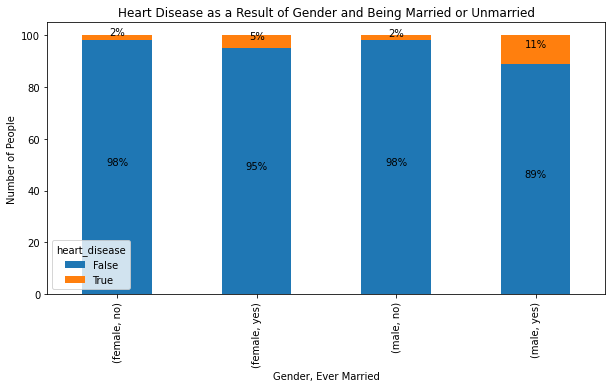

stroke                   False     True 
gender ever_married                     
female no            97.885196  2.114804
       yes           94.002999  5.997001
male   no            98.951507  1.048493
       yes           92.603550  7.396450

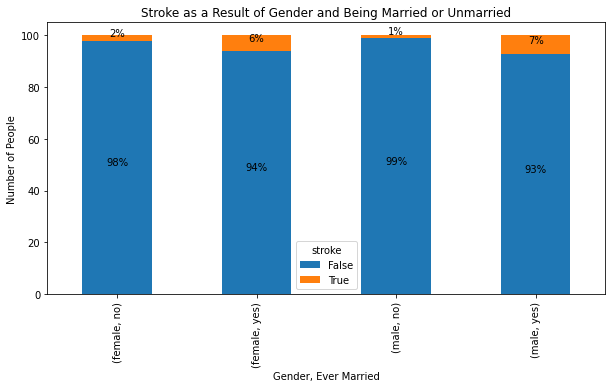

In [17]:
hyper = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.hypertension.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
hyper_ = hyper.plot.bar(figsize=(10,5),stacked=True)
display(hyper)

for rec in hyper_.patches:
    height = rec.get_height()
    hyper_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Hypertension as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

heart= pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.heart_disease.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
heart_ = heart.plot.bar(figsize=(10,5),stacked=True)
display(heart)

for rec in heart_.patches:
    height = rec.get_height()
    heart_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Heart Disease as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

gender = pd.crosstab([df_imputed['gender'], df_imputed['ever_married']], df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
gender_ = gender.plot.bar(figsize=(10,5),stacked=True)
display(gender)

for rec in gender_.patches:
    height = rec.get_height()
    gender_.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.title('Stroke as a Result of Gender and Being Married or Unmarried')
plt.xlabel('Gender, Ever Married')
plt.ylabel('Number of People')
plt.show()

<AxesSubplot:xlabel='age', ylabel='probability of stroke'>

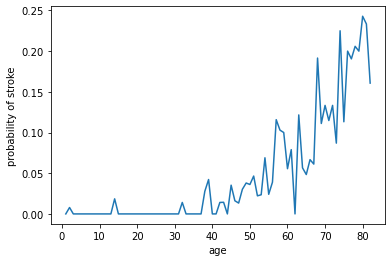

In [18]:
ages = df_imputed.age.unique()
ages.sort()
v = np.vectorize(lambda x: int(x))
ages = list(set(v(ages)))
ages.pop(0)

def stroke_probability_for(a):
    p_a_b = len(df_imputed[(df_imputed.age <= a) & (df_imputed.age > a - 1) & (df_imputed.stroke == 1.)])
    p_a   = len(df_imputed[(df_imputed.age <= a) & (df_imputed.age > a - 1)])
    return p_a_b / p_a

age_prob = list(map(lambda x: [x, stroke_probability_for(x)], ages))

stroke_age_data = pd.DataFrame(age_prob, columns=['age','probability of stroke'])

sns.lineplot(data=stroke_age_data, x="age", y="probability of stroke")
    

### Ask three interesting questions that are relevant to your dataset and explore visuals that help answer these questions. Use whichever visualization method is appropriate for your data. Important: Interpret the implications for each visualization.

**Question 1: What is more influential feature for stroke likelihood: hypertension, heart disease, or smoking status?**

stroke,False,True
hypertension,,
0.0,96.031230,3.968770
1.0,86.746988,13.253012


stroke,False,True
heart_disease,,
0.0,95.820401,4.179599
1.0,82.971014,17.028986


stroke,False,True
smoking_status,,
0,96.065574,3.934426
1,93.762183,6.237817
2,94.545455,5.454545


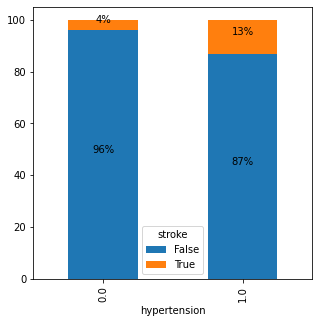

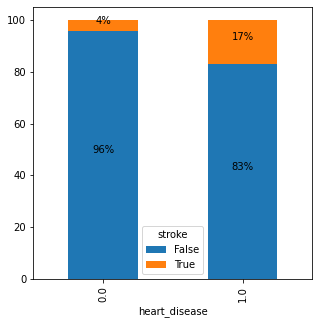

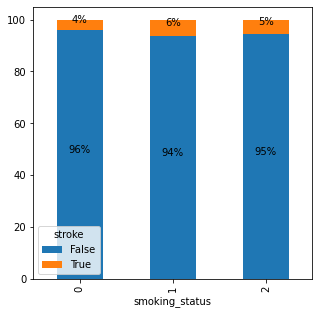

In [19]:
# plot overall cross tab with both groups

import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

# plt.figure(figsize=(15,3))
# ax1 = plt.subplot(1,3,1)
# ax2 = plt.subplot(1,3,2)
# ax3 = plt.subplot(1,3,3)

ax1= pd.crosstab([df_imputed['hypertension']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax1.plot.bar(figsize=(5,5),stacked=True)
# display(ax1)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

ax2= pd.crosstab([df_imputed['heart_disease']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_2 = ax2.plot.bar(figsize=(5,5),stacked=True)
# display(ax2)

for rec in ax_2.patches:
    height = rec.get_height()
    ax_2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

ax3 = pd.crosstab([df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_3 = ax3.plot.bar(figsize=(5,5),stacked=True)
# display(ax3)

display(ax1, ax2, ax3)
for rec in ax_3.patches:
    height = rec.get_height()
    ax_3.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

By observing the percentages on each chart, we can see how there was about 13% and 17% of individuals with hypertension and heart disease, respectively, who also had a stroke. The values for smoking status are lower - those who formerly smoked have a higher percentage of strokes, whereas those who never smoked or currently smoke have the same percentages of stroke occurrences. Therefore, we can conclude that heart disease was probably the strongest influencing factor for the likelihood of a stroke, compared to the other two health conditions.

**Question 2: Does the combination of different health conditions indicate a higher likelihood of having a stroke?**


stroke                          False      True 
hypertension heart_disease                      
0.0          0.0            96.612867   3.387133
             1.0            83.962264  16.037736
1.0          0.0            87.788018  12.211982
             1.0            79.687500  20.312500

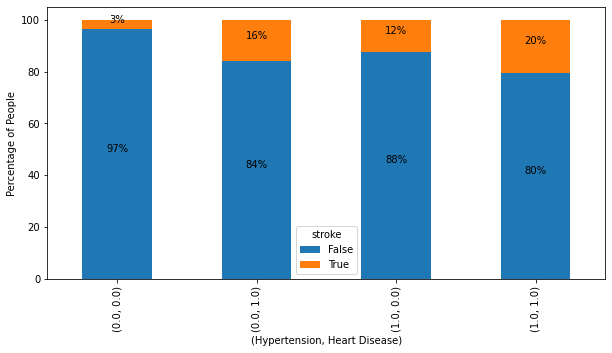

In [20]:
# plot overall cross tab with both groups

ax1= pd.crosstab([df_imputed['hypertension'], df_imputed['heart_disease']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax1.plot.bar(figsize=(10,5),stacked=True)
display(ax1)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
    
plt.ylabel('Percentage of People')
plt.xlabel('(Hypertension, Heart Disease)')

plt.show()

stroke                           False      True 
hypertension smoking_status                      
0.0          0               96.956348   3.043652
             1               94.729242   5.270758
             2               95.336077   4.663923
1.0          0               87.096774  12.903226
             1               85.064935  14.935065
             2               88.541667  11.458333

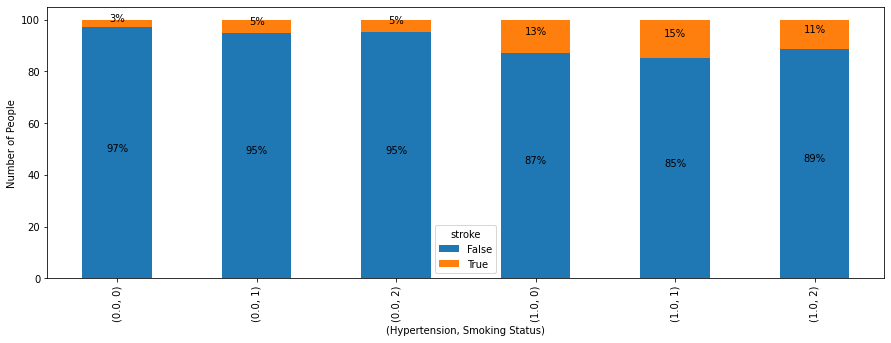

In [21]:
ax2= pd.crosstab([df_imputed['hypertension'], df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_2 = ax2.plot.bar(figsize=(15,5),stacked=True)
display(ax2)

for rec in ax_2.patches:
    height = rec.get_height()
    ax_2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.ylabel('Number of People')
plt.xlabel('(Hypertension, Smoking Status)')

plt.show()

stroke                            False      True 
heart_disease smoking_status                      
0.0           0               96.405600   3.594400
              1               94.545455   5.454545
              2               96.184211   3.815789
1.0           0               87.254902  12.745098
              1               83.486239  16.513761
              2               75.384615  24.615385

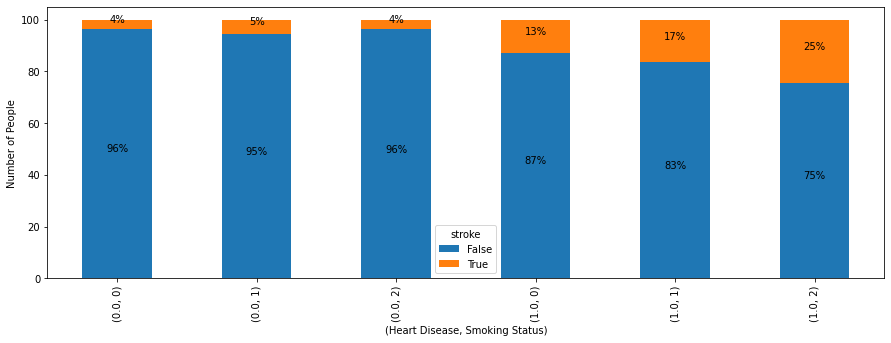

In [22]:
ax3= pd.crosstab([df_imputed['heart_disease'], df_imputed['smoking_status']],df_imputed.stroke.astype(bool)).apply(lambda r: r/r.sum()*100, axis=1)
ax_3 = ax3.plot.bar(figsize=(15,5),stacked=True)
display(ax3)

for rec in ax_3.patches:
    height = rec.get_height()
    ax_3.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

plt.ylabel('Number of People')
plt.xlabel('(Heart Disease, Smoking Status)')

plt.show()

We can see how those with both heart disease and a current smoking habit have the highest percentage of having a stroke (25%) compared to any other combination of health conditions. The second-largest percentage came from those who have hypertension and heart disease, proving how the combination of the two conditions may contribute to a higher chance of having a stroke. It also seems that those with neither hypertension nor heart_disease but have/had smoking habits had fairly low percentages of having a stroke. Those with heart disease and previous/current smoking habits have a greater chance of having a stroke compared to those with hypertension and previous/current smoking habits. We can conclude that those with combinations of diseases generally had a greater chance of having a stroke, with the combination of smoking and heart_disease being the more likely combination for a stroke, followed by hypertension and heart disease.

**Question 3: What are the best indicators of whether a person will or will not have a stroke?**

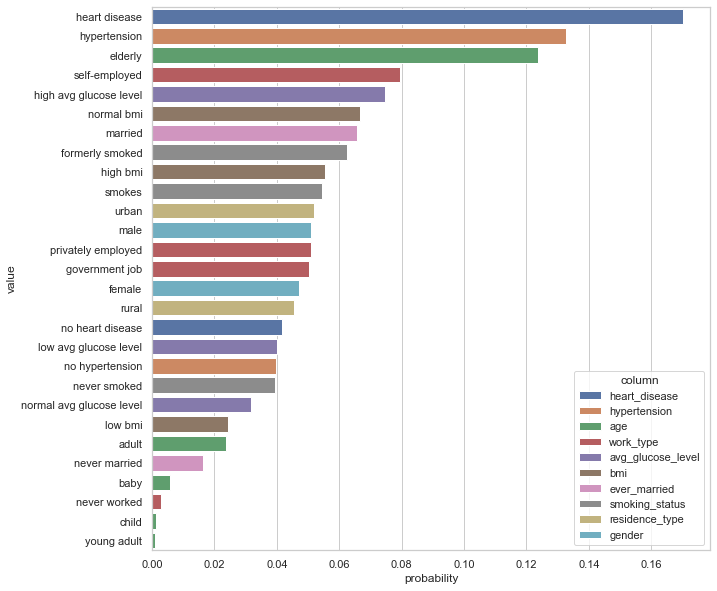

In [23]:
con_prob = []

dfv = copy.deepcopy(df_imputed)

dfv.hypertension.replace(0., "no hypertension", inplace=True)
dfv.hypertension.replace(1., "hypertension", inplace=True)
dfv.heart_disease.replace(0., "no heart disease", inplace=True)
dfv.heart_disease.replace(1., "heart disease", inplace=True)
dfv.ever_married.replace("yes", "married", inplace=True)
dfv.ever_married.replace("no", "never married", inplace=True)
dfv.work_type.replace("private", "privately employed", inplace=True)
dfv.work_type.replace("govt_job", "government job", inplace=True)
dfv.work_type.replace("never_worked", "never worked", inplace=True)
dfv.work_type.replace("children", "never worked", inplace=True)
dfv.smoking_status.replace(0, "never smoked", inplace=True)
dfv.smoking_status.replace(1, "formerly smoked", inplace=True)
dfv.smoking_status.replace(2, "smokes", inplace=True)

dfv["bmi"] = pd.qcut(dfv["bmi"],3, 
        labels=["low bmi", "normal bmi", "high bmi"])
dfv["avg_glucose_level"] = pd.qcut(dfv["avg_glucose_level"],3, 
        labels=["low avg glucose level", "normal avg glucose level", "high avg glucose level"])
dfv["age"] = pd.cut(dfv["age"],bins=[0,2,18,35,55,dfv.age.max()],
        labels=["baby","child","young adult","adult","elderly"])

cols = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
    "bmi",
    "avg_glucose_level",
    "age"
]

for c in cols:
    for v in dfv[c].unique():
        p_a_b = len(dfv[(dfv[c] == v) & (dfv["stroke"] == 1.)].index)
        p_b   = len(dfv[dfv[c] == v].index)
        con_prob.append([c, v, (p_a_b / p_b)])
        
con_prob = pd.DataFrame(con_prob, columns=['column', 'value', 'probability'])
con_prob.sort_values("probability", ascending=False, inplace=True)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (10,10))
ax = sns.barplot(ax=ax, y="value", x="probability", hue="column", dodge=False, ci=None, data=con_prob)

## Part IV - Exceptional Work

In [24]:
import umap
from sklearn.preprocessing import StandardScaler

df_imputed.ever_married.replace(to_replace= ['no', 'yes'], value = [0, 1], inplace=True)
df_imputed.gender.replace(to_replace= ['male', 'female'], value = [0, 1], inplace=True)

num_data = df_imputed[
    [
        "hypertension",
        "heart_disease",
        "stroke",
        "gender",
        "ever_married",
        "smoking_status",
        "bmi",
        "avg_glucose_level",
        "age",
    ]
]

standard_num_data = StandardScaler().fit_transform(num_data)
embedding = umap.UMAP().fit_transform(standard_num_data)
embedding

array([[18.226652 ,  4.530487 ],
       [18.042501 , 16.385029 ],
       [18.334406 ,  4.634625 ],
       ...,
       [ 8.5330515,  9.892927 ],
       [-8.129891 , 15.961671 ],
       [ 4.7816052, -1.3687505]], dtype=float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              5109 non-null   int64  
 1   id                 5109 non-null   int64  
 2   gender             5109 non-null   int64  
 3   age                5109 non-null   float64
 4   hypertension       5109 non-null   float64
 5   heart_disease      5109 non-null   float64
 6   ever_married       5109 non-null   int64  
 7   work_type          5109 non-null   object 
 8   residence_type     5109 non-null   object 
 9   avg_glucose_level  5109 non-null   float64
 10  bmi                5109 non-null   float64
 11  smoking_status     5109 non-null   int64  
 12  stroke             5109 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 519.0+ KB


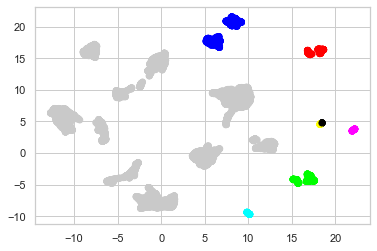

In [25]:
df_imputed.info()

df_new = pd.DataFrame(standard_num_data[:,0:3], columns=[
        "hypertension_num",
        "heart_disease_num",
        "stroke_num"
])

result = pd.concat([df_new, df_imputed[[
        "hypertension",
        "heart_disease",
        "stroke"
]]], axis=1)

# 0 is healthy
# 1 is stroke
# 2 is heart_disease
# 3 is stroke and heart_disease
# 4 is hypertension
# 5 is hypertension and stroke
# 6 is hypertension and heart_disease
# 7 is all three

def get_color(array):
    string = ""
    for s in array:
        string += str(int(s))
    return int(string,2)

result['color'] = result[[
        "hypertension",
        "heart_disease",
        "stroke"]].apply(get_color, axis=1)

colors = {
    'gray': '#C9C9C9',
    'red': '#FF0000', 
    'green': '#00FF00', 
    'yellow': '#FFFF00',
    'blue': '#0000FF',
    'purple': '#FF00FF',
    'cyan': '#00FFFF',
    'black': '#000000'
}

chart_colors = [
    colors['gray'], # healthy
    colors['red'], # stroke
    colors['green'], # heart_disease
    colors['yellow'], # stroke and heart_disease
    colors['blue'], # hypertension
    colors['purple'], # hypertension and stroke
    colors['cyan'], # hypertension and heart_disease
    colors['black']  # all three
]

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[chart_colors[x] for x in result.color]
)